# fMRI_Delay
## Notebook for experimentation on Results Validation

In [2]:
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy import stats, sparse
from itertools import combinations, permutations

import pickle
import os

import pandas as pd

import fmri_delay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading esfmri Data

In [79]:
import h5py

def get_stim_parcel(path_to_esfmri):
    path_to_parcels = 'esfmri_connectivity/esfmri_connectivity/stimulation_sites/stimsite2parcel.tsv'

    parcel_DF = pd.read_csv(path_to_data + path_to_parcels, '\t')
    
    filtered_DF = parcel_DF.loc[parcel_DF['parcel_included_in_sub_mask'] == True]\
                            .drop(columns = ['Unnamed: 0','parcel_included_in_sub_mask'])\
                            .sort_values(['subject', 'run']).reset_index(drop = True)
    
    filtered_DF['subj_run'] = 'sub-'+filtered_DF.subject.astype(str)+'-es_run-0'+filtered_DF.run.astype(str)
    
    return filtered_DF

def get_isig(path_to_TA):
    isig_path = 'TotalActivation/Innovation.mat'
    isig_thresh_path = 'Thresholding/Alpha_5_95_Fraction_0DOT05/SignInnov.mat'
    param_path = 'Thresholding/Alpha_5_95_Fraction_0DOT05/param.mat'
    
    #isig = h5py.File(path_to_TA+isig_path, 'r')['Innovation'][()]
    isig_s = h5py.File(path_to_TA+isig_thresh_path, 'r')['SignInnov'][()]
    TA_param = h5py.File(path_to_TA+param_path, 'r')['param']
    
    #return isig, isig_s, TA_param
    return isig_s, TA_param

def run_esfmri_experiment(path, run_name = 'esfmri_fixedTR', n_rand = 100, jitter = [0], pre_thresh = [0.7],
                          window = 1, parallel = True, chunksize = 20, n_cores = None, subset = 0,
                          measure = True):
    
    parcel_data = get_stim_parcel(path)
    parcel_filter = parcel_data.subj_run.tolist()
    
    esfmri_path = path+'esfmri_data/'
    
    dir_list = np.array(os.listdir(esfmri_path))
    TA_path = '/TA_results/{}/'.format(run_name)
    
    isig_path = 'TotalActivation/Innovation.mat'
    isig_thresh_path = 'Thresholding/Alpha_5_95_Fraction_0DOT05/SignInnov.mat'
    
    # Keeps only directories of subjects
    dir_list = dir_list[[dir_name.startswith('sub') for dir_name in dir_list]]
    
    # Keeps only relevant subjects and run
    dir_list = sorted(dir_list[[dir_name in parcel_filter for dir_name in dir_list]])
    
    if subset:
        dir_list = dir_list[:subset]
    
    n_subj_run = len(dir_list)
    
    if not measure:
        esfmri_fixed = [0]*n_subj_run
        esfmri_thresh = [0]*n_subj_run
        
    esfmri_processed = [0]*n_subj_run
    
    esfmri_real = [0]*n_subj_run
    esfmri_rand = [0]*n_subj_run
    
    for sub_run_id, sub_dir in enumerate(dir_list):
        print('Measuring', sub_dir, '...')
        
        isig_s, TA_param = get_isig(esfmri_path+sub_dir+TA_path)
        
        fixed = fmri_delay.fix_temporal_dim(isig_s, TA_param)
        
        filtered = np.empty((len(pre_thresh), len(fixed), len(fixed[0])))
        
        for pt_id, pt in enumerate(pre_thresh):
            thresholded = fmri_delay.isig_threshold(fixed, z_thresh = pt)
            filtered[pt_id] = fmri_delay.local_max_filter(thresholded, window = window)
            
            if measure:
                print('    Z Threshold = {}'.format(pt))
                r_meas = fmri_delay.delay_measure(filtered[pt_id], parallel = parallel,
                                                  chunksize = chunksize,n_cores = n_cores)
                
                if pt_id == 0:
                    n_reg = len(r_meas)
                    
                    real_meas = np.empty((len(pre_thresh), n_reg, n_reg))
                    rand_meas = np.empty((len(jitter), len(pre_thresh), n_rand, n_reg, n_reg))
                    
                real_meas[pt_id] = r_meas
                
                for jit_id, jit in enumerate(jitter):
                    # Shuffling of innovations
                    randomized = fmri_delay.permute_innovations(filtered[pt_id], n_rand, jitter = jit)

                    for rand_id, rand_data in enumerate(randomized):
                        rand_meas[jit_id, pt_id, rand_id] = fmri_delay.delay_measure(rand_data, parallel = parallel,
                                                                                     chunksize = chunksize,
                                                                                     n_cores = n_cores)
        esfmri_processed[sub_run_id] = filtered
        
        if measure:
            esfmri_real[sub_run_id] = real_meas
            esfmri_rand[sub_run_id] = rand_meas
            
            esfmri_exp = {'esfmri_processed':esfmri_processed, 'esfmri_real':esfmri_real,
                          'esfmri_rand':esfmri_rand, 'parcel_data':parcel_data,
                          'pre_thresh':pre_thresh, 'jitter':jitter}
            
            with open('../pickle_data/esfmri_prethresh.pickle', 'wb') as f:
                pickle.dump(esfmri_exp, f)
        else:
            esfmri_fixed[sub_run_id] = fixed
            esfmri_thresh[sub_run_id] = thresholded
        
    if measure:
        return esfmri_processed, esfmri_real, esfmri_random, parcel_data
    else:
        return esfmri_fixed, esfmri_thresh, esfmri_processed

In [75]:
path_to_data = '/Users/AlexCionca/Documents/PDM/_Data/'

esfmri_fixed, esfmri_thresholded, esfmri_processed = run_esfmri_experiment(path_to_data,
                                                                           n_rand = 1,
                                                                           jitter = 0,
                                                                           subset = 0,
                                                                           measure = False)

Measuring sub-292-es_run-01 ...
Measuring sub-292-es_run-04 ...
Measuring sub-292-es_run-05 ...
Measuring sub-294-es_run-01 ...
Measuring sub-302-es_run-01 ...
Measuring sub-303-es_run-01 ...
Measuring sub-303-es_run-04 ...
Measuring sub-307-es_run-02 ...
Measuring sub-307-es_run-07 ...
Measuring sub-314-es_run-02 ...
Measuring sub-314-es_run-03 ...
Measuring sub-314-es_run-04 ...
Measuring sub-314-es_run-05 ...
Measuring sub-316-es_run-03 ...
Measuring sub-316-es_run-04 ...
Measuring sub-316-es_run-06 ...
Measuring sub-316-es_run-07 ...
Measuring sub-320-es_run-01 ...
Measuring sub-320-es_run-04 ...
Measuring sub-320-es_run-05 ...
Measuring sub-320-es_run-06 ...
Measuring sub-330-es_run-02 ...
Measuring sub-330-es_run-03 ...
Measuring sub-330-es_run-05 ...
Measuring sub-335-es_run-01 ...
Measuring sub-335-es_run-02 ...
Measuring sub-335-es_run-03 ...
Measuring sub-335-es_run-05 ...
Measuring sub-335-es_run-06 ...
Measuring sub-335-es_run-08 ...
Measuring sub-376-es_run-01 ...
Measurin

In [6]:
esfmri_isig = {'esfmri_fixed':esfmri_fixed, 'esfmri_thresholded':esfmri_thresholded,
               'esfmri_processed':esfmri_processed}

with open('../pickle_data/esfmri_isig.pickle', 'wb') as f:
    pickle.dump(esfmri_isig, f)

In [80]:
path_to_esfmri = '/Users/AlexCionca/Documents/PDM/_Data/'

esfmri_processed, esfmri_real, esfmri_random = run_esfmri_experiment(path_to_esfmri, n_rand = 1,
                                                                     pre_thresh = [0, 1],
                                                                     jitter = [0, 10], subset = 10)

Measuring sub-292-es_run-01 ...
    Z Threshold = 0
    Z Threshold = 1
Measuring sub-292-es_run-04 ...
    Z Threshold = 0


KeyboardInterrupt: 

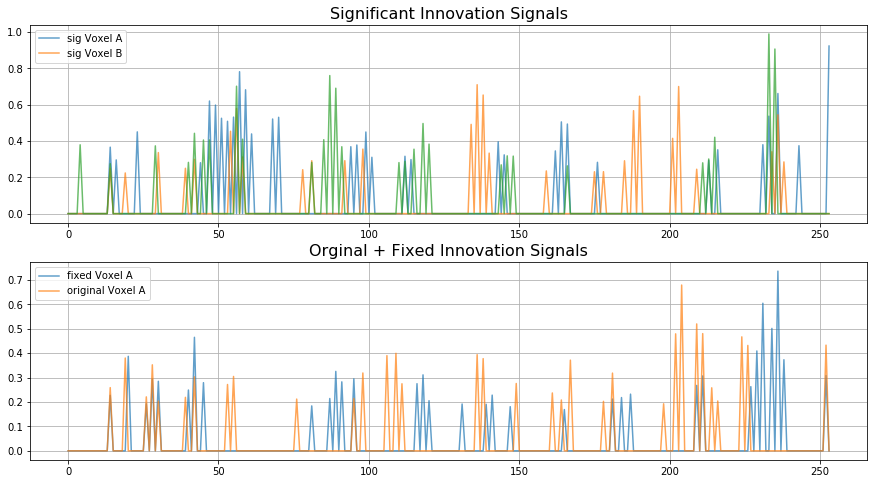

In [194]:
isig_processed = esfmri_processed[0]

fig, ax = plt.subplots(figsize = (15, 8))

plt.subplot(2, 1, 1)
plt.title('Significant Innovation Signals', fontsize = 16)
plt.plot(isig_processed[:3].T, alpha = 0.7)
plt.legend(['sig Voxel A', 'sig Voxel B'])
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Orginal + Fixed Innovation Signals', fontsize = 16)
plt.plot(isig_processed[3:5].T, alpha = 0.7)

plt.legend(['fixed Voxel A', 'original Voxel A'])
plt.grid()

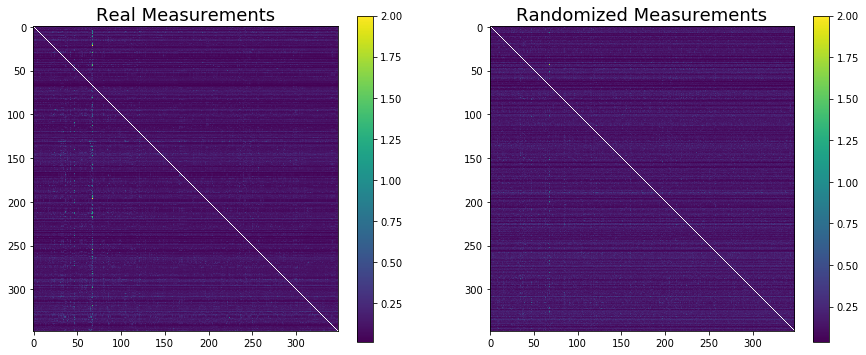

In [210]:
fig, ax = plt.subplots(figsize = (15, 6))

titles = ['Real Measurements', 'Randomized Measurements']

for i, toplot in enumerate([esfmri_real[0], esfmri_random[0][0]]):
    plt.subplot(1, 2, 1 + i)
    
    plt.title(titles[i], fontsize = 18)
    
    plt.imshow(1/toplot, vmax = 2)
    plt.colorbar()

# LOADING OF ESFMRI EXP

In [3]:
#esfmri_exp = {'esfmri_processed':esfmri_processed, 'esfmri_real':esfmri_real,
#                          'esfmri_rand':esfmri_rand, 'parcel_data':parcel_data,
#                          'pre_thresh':pre_thresh, 'jitter':jitter}

with open('../pickle_data/CH_esfmri_fullrun_23subj.pickle', 'rb') as f:
    esfmri_fullrun = pickle.load(f)
    
esfmri_processed = esfmri_fullrun['esfmri_processed']
esfmri_real = esfmri_fullrun['esfmri_real']
esfmri_rand = esfmri_fullrun['esfmri_rand']
parcel_data = esfmri_fullrun['parcel_data']
jitter = esfmri_fullrun['jitter']
pre_thresh = esfmri_fullrun['pre_thresh']

In [ ]:
pre_thresh = np.arange(-0.8, 0, 0.02)

n_subjrun_nomeas = len(isig_fixed)

n_innov = np.empty((n_subjrun_nomeas, len(pre_thresh), 2))
act_perc = np.empty((n_subjrun_nomeas, len(pre_thresh), 2))

for subj in range(n_subjrun_nomeas):
    for pt_id, pt in enumerate(pre_thresh):
        thresh = fmri_delay.isig_threshold(isig_fixed[subj], z_thresh = pt)
        
        innov_per_parcel = np.sum(thresh > 0, axis = 1)
        
        activity_percentage = innov_per_parcel/len(thresh[0])
        
        act_perc[subj, pt_id] = activity_percentage.mean(), activity_percentage.std()
        n_innov[subj, pt_id] = innov_per_parcel.mean(), innov_per_parcel.std()

/Users/AlexCionca/miniconda3/PROJ/_PDM/fmri_delay/fmri_delay/validation.py:123: RuntimeWarning: invalid value encountered in less
  bin_results = (real_meas < empirical_bound).astype(int)


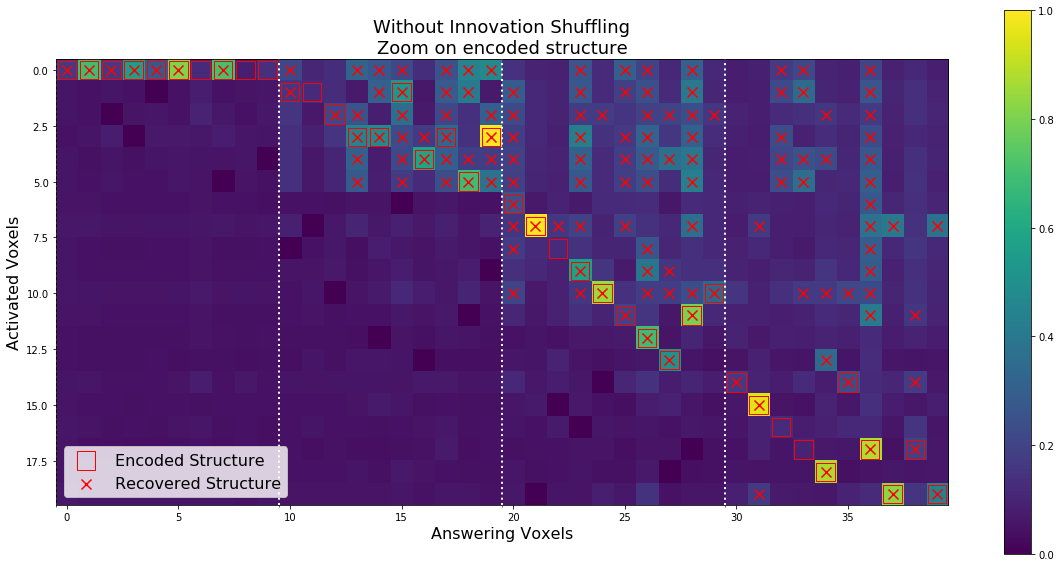

In [77]:
fig, ax = plt.subplots(figsize = (20, 10))

highlight = ([i for i in unq for j in fol_id],
             [j for i in unq for j in fol_id])

expected = fmri_delay.get_encoded_structure(seed_choice, fol_id, n_reg, fol_inter = True)

encoded = np.where(expected[highlight].reshape((len(unq), -1)) == 1)

plt.title('Without Innovation Shuffling\nZoom on encoded structure', fontsize = 18)

nonan = del_std_pattern.copy()

nonan[np.arange(n_reg), np.arange(n_reg)] = 100
#nonan[np.isnan(nonan)] = 100

plt.imshow(1/nonan[highlight].reshape((len(unq), -1)))
plt.scatter(encoded[1], encoded[0], marker = 's', color="none",
            edgecolor="red", s = 340, label = 'Encoded Structure')

alevel = 1

bin_res = fmri_delay.empirical_null_dist(del_std_pattern, del_std_perm, alpha_level = alevel)
bin_loc = np.where(bin_res[highlight].reshape((len(unq), -1)) == 1)

#plt.scatter(bin_loc[1], bin_loc[0], marker = 'o', color="none",
#            edgecolor="red", s = 340)

plt.scatter(bin_loc[1], bin_loc[0], marker = 'x', color="red", s = 100,
            label = 'Recovered Structure')

ax.set_xticks([-0.5, -0.5, -0.5, -0.5] + np.arange(len(folevels)) * folevels, minor = True);
#ax1.set_yticks([-0.5, -0.5, -0.5, -0.5] + np.arange(len(folevels)) * folevels, minor = True);
ax.grid(which='minor', color='w', linestyle=':', linewidth=2)

plt.xlabel('Answering Voxels', fontsize = 16)
plt.ylabel('Activated Voxels', fontsize = 16)
plt.legend(fontsize = 16)

plt.colorbar()

## Evaluation of measurement on with other voxels (Ranking)

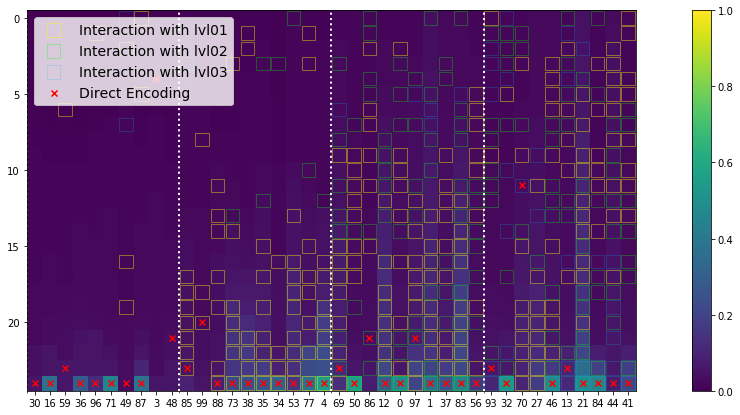

In [78]:
fig, ax = plt.subplots(figsize = (20, 7))

nonan = del_std_pattern.copy()
nonan[np.arange(n_reg), np.arange(n_reg)] = 100

fol_res = 1/nonan[:, fol_id]

srtd = np.sort(fol_res, axis = 0)[-25:]
asrtd = np.argsort(fol_res, axis = 0)[-25:]

plt.imshow(srtd, vmax = 1)

lvlencode = np.zeros_like(asrtd)
lvl_indicator = fol_id.reshape((-1, 10))

for lvl in [0, 1, 2]:
    isitin = np.array([valsrtd in lvl_indicator[lvl]
                         for rowsrtd in asrtd for valsrtd in rowsrtd])
    
    lvlencode += isitin.reshape((25, -1))*(1+lvl)

direct_enc = np.where(expected[asrtd, fol_id] == 1)

marksize = 180

for lvl, col in zip([0, 1, 2], ['yellow','lime', 'deepskyblue']):
    lvl_enc = np.where(lvlencode == lvl+1)
    plt.scatter(lvl_enc[1], lvl_enc[0], marker = 's', color="none", alpha = 0.4-lvl*0.1,
                edgecolor=col, s = marksize,
                label = 'Interaction with lvl{:02d}'.format(lvl+1))


#plt.scatter(direct_enc[1], direct_enc[0], marker = 's', color="none",
#            edgecolor="red", s = marksize, label = 'Direct Encoding')

plt.scatter(direct_enc[1], direct_enc[0], marker = 'x', color="red",
            s = marksize*0.2, label = 'Direct Encoding')



ax.set_xticks([-0.5, -0.5, -0.5, -0.5] + np.arange(len(folevels)) * folevels, minor = True);
ax.grid(which='minor', color='w', linestyle=':', linewidth=2)

plt.xticks(np.arange(40), fol_id)

plt.legend(loc = 'upper left', fontsize = 14)

plt.colorbar()

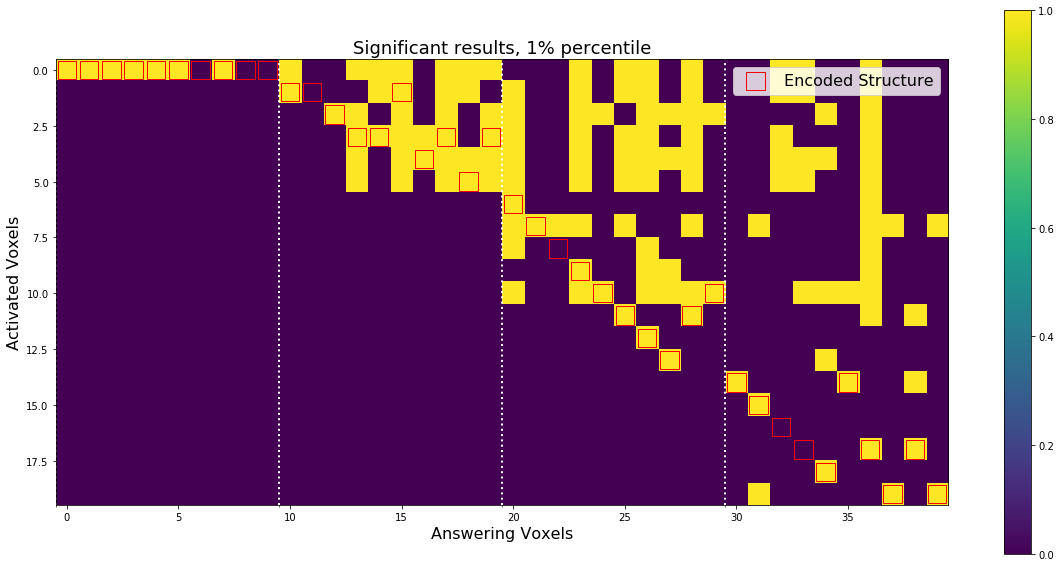

In [79]:
fig, ax = plt.subplots(figsize = (20, 10))

alevel = 1

bin_res = fmri_delay.empirical_null_dist(del_std_pattern, del_std_perm, alpha_level = alevel)

plt.title('Significant results, {}% percentile'.format(alevel), fontsize = 18)

to_show = bin_res[highlight].reshape((len(unq), -1))

plt.imshow(to_show)
plt.scatter(encoded[1], encoded[0], marker = 's', color="none",
            edgecolor="red", s = 340)

ax.set_xticks([-0.5, -0.5, -0.5, -0.5] + np.arange(len(folevels)) * folevels, minor = True);
#ax1.set_yticks([-0.5, -0.5, -0.5, -0.5] + np.arange(len(folevels)) * folevels, minor = True);
ax.grid(which='minor', color='w', linestyle=':', linewidth=2)

plt.xlabel('Answering Voxels', fontsize = 16)
plt.ylabel('Activated Voxels', fontsize = 16)
plt.legend(['Encoded Structure'], fontsize = 16)

plt.colorbar()

In [80]:
seed_choice.reshape((4, -1))

array([[29, 29, 29, 29, 29, 29, 29, 29, 29, 29],
       [96, 96, 59, 36, 36, 96, 48, 36, 87, 36],
       [35, 99, 85,  4, 88, 77, 38, 34, 77, 88],
       [ 0, 86, 12, 83, 37,  0, 83, 50, 83, 50]])

## Evaluation of FalsePositives and FalseNegatives

In [96]:
n_exp = 10
n_reg = 100
n_timep = 400
n_perm = 100

fol_levels = [10, 10, 10, 10]
delays = [5, 8, 8, 10]

alevel = 5

replic_prob = np.arange(50, 110, 10)

dc_patt = np.empty((n_exp, len(replic_prob), n_reg, n_reg))
dc_perm = np.empty((n_exp, len(replic_prob), n_perm, n_reg, n_reg))
expected = np.empty_like(dc_patt)

bin_res = np.empty_like(dc_patt)

for exp in range(n_exp):
    print('Experiment No{}'.format(exp + 1))
    for rp_i, rp in enumerate(replic_prob):
        dc_patt[exp, rp_i], dc_perm[exp, rp_i], expected[exp, rp_i] = fmri_delay.gen_sim_data(
            n_reg = n_reg, n_timep = n_timep, n_max_perm = n_max_perm, n_seeds = 1,
            n_followers = 40, activ_proba = [5e-2, rp], delay = delays, noise = 0.1,
            fol_levels = fol_levels)
        
        bin_res[exp, rp_i] = fmri_delay.empirical_null_dist(dc_patt[exp, rp_i],
                                                            dc_perm[exp, rp_i],
                                                            alpha_level = alevel)

Experiment No1
Experiment No2
Experiment No3
Experiment No4
Experiment No5


Experiment No6
Experiment No7
Experiment No8
Experiment No9
Experiment No10


In [102]:
import pickle
jitter=0

# Creating storage object
esfmri_nojit = {'n_exp':n_exp, 'n_reg':n_reg, 'n_perm':n_perm, 'n_timep':n_timep,
                'fol_levels':fol_levels, 'delay':delays, 'alevel':alevel, 'jitter':jitter,
                'replic_prob':replic_prob, 'dc_patt':dc_patt, 'dc_perm':dc_perm,
                'expected':expected, 'bin_res':bin_res}

# Saving experiments results in a pickle file
with open('exp_data/esfmri_jitt0.pickle', 'wb') as f:
    pickle.dump(esfmri_nojit, f)

In [ ]:
n_exp = 10
n_reg = 100
n_timep = 400
n_perm = 100

fol_levels = [10, 10, 10, 10]
delays = [5, 8, 8, 10]

alevel = 5
jitter = 10

replic_prob = np.arange(50, 110, 10)

dc_patt = np.empty((n_exp, len(replic_prob), n_reg, n_reg))
dc_perm = np.empty((n_exp, len(replic_prob), n_perm, n_reg, n_reg))
expected = np.empty_like(dc_patt)

bin_res = np.empty_like(dc_patt)

for exp in range(n_exp):
    print('Experiment No{}'.format(exp + 1))
    for rp_i, rp in enumerate(replic_prob):
        dc_patt[exp, rp_i], dc_perm[exp, rp_i], expected[exp, rp_i] = fmri_delay.gen_sim_data(
            n_reg = n_reg, n_timep = n_timep, n_max_perm = n_max_perm, n_seeds = 1,
            n_followers = 40, activ_proba = [5e-2, rp], delay = delays, noise = 0.1,
            fol_levels = fol_levels, jitter = jitter)
        
        bin_res[exp, rp_i] = fmri_delay.empirical_null_dist(dc_patt[exp, rp_i],
                                                            dc_perm[exp, rp_i],
                                                            alpha_level = alevel)

In [ ]:
# Creating storage object
esfmri_nojit = {'n_exp':n_exp, 'n_reg':n_reg, 'n_perm':n_perm, 'n_timep':n_timep,
                'fol_levels':fol_levels, 'delay':delays, 'alevel':alevel, 'jitter':jitter,
                'replic_prob':replic_prob, 'dc_patt':dc_patt, 'dc_perm':dc_perm,
                'expected':expected, 'bin_res':bin_res}

# Saving experiments results in a pickle file
with open('esfmri_jitt10.pickle', 'wb') as f:
    pickle.dump(esfmri_nojit, f)

In [11]:
fal_neg = np.empty((len(permut_tests), 2))
fal_pos = np.empty_like(permut_tests)

# Computation of recovery scores
#for perm_id, sig_res in enumerate(signif):
for perm_id, sig_res in enumerate(one_tailed):
    fal_neg[perm_id], fal_pos[perm_id] = fmri_delay.recovery_score(sig_res, expected, True)

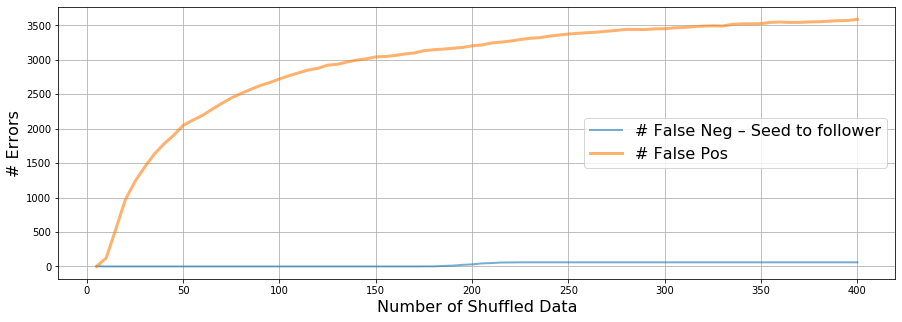

In [12]:
fig, ax = plt.subplots(figsize = (15, 5))

plt.plot(permut_tests, fal_neg[:,0], alpha = 0.6,
         label = '# False Neg – Seed to follower', linewidth = 2)
#plt.plot(permut_tests, fal_neg[:,1], alpha = 0.6,
#         label = '# False Neg – Follower to follower', linewidth = 2)
plt.plot(permut_tests, fal_pos, alpha = 0.6,
         label = '# False Pos', linewidth = 3)

plt.xlabel('Number of Shuffled Data', fontsize = 16)
plt.ylabel('# Errors', fontsize = 16)

#plt.axis([1, 203, -10, 400])

plt.grid()
plt.legend(fontsize = 16)

In [13]:
def interactive_significance(step, n_permut, sig_data, p_data, r_data, ci = None):
    all_sigs = np.where(sig_data[n_permut] == 1)
    
    fig, ax = plt.subplots(figsize = (14, 8))

    my_real = p_data[all_sigs[0][step], all_sigs[1][step]]
    my_rand = r_data[:, all_sigs[0][step], all_sigs[1][step]]
    
    _, p_val = stats.ttest_1samp(my_rand[np.random.choice(len(my_rand), n_permut+5)], 
                                 my_real)
    
    plt.subplot(2, 1, 1)
    
    plt.title('{} Rand. Measurement Used,  Matrix Index {},  p_value: {:1.3e}'
              .format(n_permut + 5, (all_sigs[0][step], all_sigs[1][step]), p_val),
              fontsize = 18)

    plt.plot(np.full_like(my_rand, my_real), label = 'Real Measurement')
    plt.plot(my_rand, label = 'Shuffled Measurement')
    plt.plot(np.full_like(my_rand, my_rand.mean()), ':', label = 'Mean of rand. Measurement')
    
    if ci is not None:
        #lower = ci[n_permut, 0, all_sigs[0][step], all_sigs[1][step]]
        upper = ci[n_permut, 1, all_sigs[0][step], all_sigs[1][step]]
        
        #plt.plot(np.full_like(my_rand, lower), ':', label = 'Lower CI')
        plt.plot(np.full_like(my_rand, upper), ':', label = 'Upper CI')
    
    plt.xlabel('Shuffle data id', fontsize = 18)
    plt.ylabel('Delay measurement', fontsize = 18)
    
    plt.legend()
    plt.grid()
    
    plt.subplot(2, 1, 2)
    
    plt.title('Real Measurement on Shuffled Distribution Histogram', fontsize = 18)
    
    plt.hist(my_rand, 30, label = 'Shuffled Distribution')
    plt.plot(np.full(10, my_real), np.arange(10), 'r--', linewidth = 2,
             label = 'Real Measurement')
    
    if ci is not None:
        plt.plot(np.full(8, upper), np.arange(8), '--', linewidth = 2,
                 label = 'Upper bound of CI')
    
    plt.xlabel('Delay measurement', fontsize = 18)
    plt.ylabel('Frequency', fontsize = 18)
    
    plt.legend(fontsize = 16)
    plt.grid()
    
    plt.tight_layout()
    
    return

interact(interactive_significance,
         step = widgets.IntSlider(min = 0, max = 100, step = 1, value = 0),
         n_permut = widgets.IntSlider(min = 0, max = 95, step = 1, value = 0),
         sig_data = fixed(one_tailed),
         p_data = fixed(1/del_std_pattern),
         r_data = fixed(1/del_std_perm), ci = fixed(None))

interactive(children=(IntSlider(value=0, description='step'), IntSlider(value=0, description='n_permut', max=9…

<function __main__.interactive_significance(step, n_permut, sig_data, p_data, r_data, ci=None)>

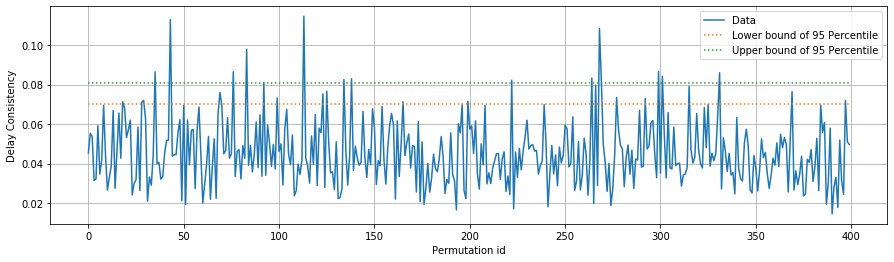

In [14]:
def bootstrap_percentile_ci(shuff_data, percent = 95, alpha_level = 0.05, n_bs = 100):
    
    n_samples = len(shuff_data)
    true_perc = np.percentile(shuff_data, percent)
    
    resampled = np.random.choice(shuff_data, (n_bs, n_samples), replace = True)
    resampled_percentiles = np.percentile(resampled, percent, axis = 1)
    
    # No need to compute lower bound of CI
    lower = np.percentile(resampled_percentiles, 100*alpha_level/2,
                          interpolation = 'nearest')
    upper = np.percentile(resampled_percentiles, 100*(1-alpha_level/2),
                          interpolation = 'nearest')
    
    return (lower, upper)

low, up = bootstrap_percentile_ci(1/del_std_perm[:, 0, 1], n_bs = 10)

fig, ax = plt.subplots(figsize = (15, 4))
plt.plot(1/del_std_perm[:, 0, 1], label = 'Data')
plt.plot(np.full((n_max_perm), low), ':', label = 'Lower bound of 95 Percentile')
plt.plot(np.full((n_max_perm), up), ':', label = 'Upper bound of 95 Percentile')

plt.xlabel('Permutation id')
plt.ylabel('Delay Consistency')

plt.grid()

plt.legend()

In [15]:
from multiprocessing import Pool
from itertools import repeat
import time

def par_bootstrap_bin(real_data, rand_data, percent = 95, alpha_level = 0.05, n_bs = 100,
                     return_ci = False):
    n_shuff, n_reg = len(rand_data), len(real_data)
    
    rand_vec = rand_data.reshape((n_shuff, -1)).T
    real_vec = real_data.flatten()
    
    bin_bs = np.full(len(rand_vec), np.nan)
    bs_ci = np.full((len(rand_vec), 2), np.nan)
    
    data_param = zip(rand_vec, repeat(percent), repeat(alpha_level), repeat(n_bs))
    
    # Parallel estimation of confidence interval with Bootstrap Resampling
    with Pool(processes = None) as pool:
        for idx, pool_res in enumerate(pool.starmap(bootstrap_percentile_ci, data_param)):
            if not np.isnan(pool_res[1]):
                bin_bs[idx] = int(real_vec[idx] > pool_res[1])
                bs_ci[idx] = pool_res
    
    return bin_bs.reshape((n_reg, -1)), bs_ci.reshape((2, n_reg, -1))

In [224]:
n_exp, n_resamples, n_reg, n_max_perm = 5, 100, 100, 200

permut_tests = np.arange(5, n_max_perm + 5, 5)

bootstrap_binary = np.full((n_exp, len(permut_tests), n_reg, n_reg), np.nan)
bs_ci = np.empty((n_exp, n_max_perm, 2, n_reg, n_reg))

dc_patt = np.empty((n_exp, n_reg, n_reg))
dc_perm = np.empty((n_exp, n_max_perm, n_reg, n_reg))
expected = np.empty((n_exp, n_reg, n_reg))

fal_ne = np.empty((n_exp, len(permut_tests), 2))
fal_po = np.empty((n_exp, len(permut_tests)))

for exp in range(n_exp):
    print('Experiment No.{:02d}'.format(exp + 1))
    print('Generating data...')
    dc_patt[exp], dc_perm[exp], expected[exp] = gen_sim_data(n_reg = n_reg,
                                                             n_max_perm = n_max_perm,
                                                             n_seeds = 10,
                                                             n_followers = 60,
                                                             activ_proba = [5e-2, 95],
                                                             delay = 5, noise = 0.1)
    print('Assessing performances...')
    
    for n_p_id, n_perm in enumerate(permut_tests):
        if n_perm == 100:
            print('Testing with 100 permutations...')
        perm_choice = np.random.choice(n_max_perm, n_perm, replace = False)
        sig_res, bs_ci[exp, n_p_id] = par_bootstrap_bin(1/dc_patt[exp],
                                                        1/dc_perm[exp, perm_choice],
                                                        percent = 95, alpha_level = 0.05,
                                                        n_bs = 100)
        
        bootstrap_binary[exp, n_p_id] = sig_res
        
        fal_ne[exp, n_p_id], fal_po[exp, n_p_id] = fmri_delay.recovery_score(sig_res,
                                                                             expected[exp],
                                                                             True)

Experiment No.01
Generating data...
Assessing performances...
Testing with 100 permutations...
Experiment No.02
Generating data...
Assessing performances...
Testing with 100 permutations...
Experiment No.03
Generating data...
Assessing performances...
Testing with 100 permutations...
Experiment No.04
Generating data...
Assessing performances...
Testing with 100 permutations...
Experiment No.05
Generating data...
Assessing performances...
Testing with 100 permutations...


In [239]:
which = 0

interact(interactive_significance,
         step = widgets.IntSlider(min = 0, max = 100, step = 1, value = 0),
         n_permut = widgets.IntSlider(min = 0, max = len(permut_tests) - 1,
                                      step = 1, value = 0),
         sig_data = fixed(bootstrap_binary[which]),
         p_data = fixed(1/dc_patt[which]),
         r_data = fixed(1/dc_perm[which]), ci = fixed(bs_ci[which]))

interactive(children=(IntSlider(value=0, description='step'), IntSlider(value=0, description='n_permut', max=3…

<function __main__.interactive_significance(step, n_permut, sig_data, p_data, r_data, ci=None)>

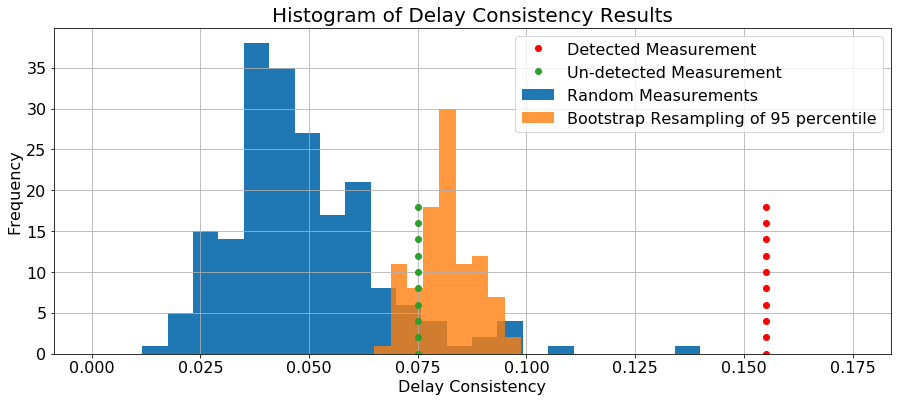

In [315]:
fig, ax = plt.subplots(figsize = (15, 6))

plt.title('Histogram of Delay Consistency Results', fontsize = 20)

plt.hist(1/dc_perm[0, :, 0, 2], bins = 30, range = (0, 0.175), label = 'Random Measurements')

resamp = np.random.choice(1/dc_perm[0, :, 0, 2], (100, 200), replace = True)

plt.hist(np.percentile(resamp, 95, axis = 1), bins = 20,
         range = (0.05, 0.125), alpha = 0.8,
         label = 'Bootstrap Resampling of 95 percentile')
#plt.hist(np.random.normal(np.full(100, 0.1), 0.005), bins = 30,
#         range = (0.075, 0.125), alpha = 0.8,
#         label = 'Bootstrap Resampling of 95 percentile')

plt.plot(np.full(10, 0.155), np.arange(0, 20, 2), 'ro', linewidth = 4,
         label = 'Detected Measurement')

plt.plot(np.full(10, 0.075), np.arange(0, 20, 2), 'o', linewidth = 4,
         label = 'Un-detected Measurement')

plt.plot()

plt.xlabel('Delay Consistency', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(labelsize = 16)

plt.grid()
plt.legend(fontsize = 16)
plt.savefig('The_Draft/Valid_bootstrap')

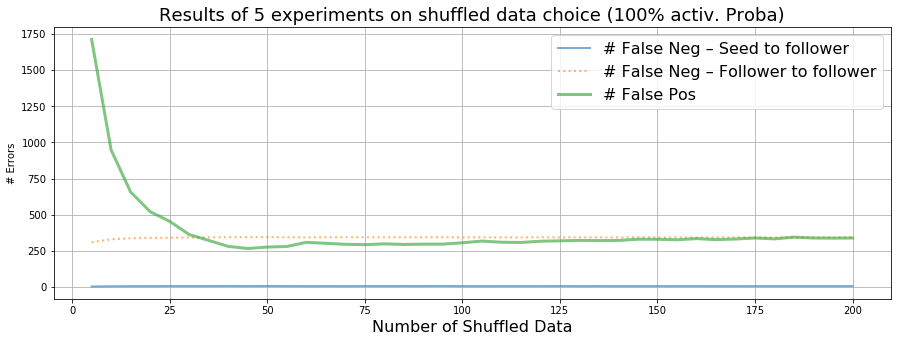

In [240]:
fig, ax = plt.subplots(figsize = (15, 5))

plt.title('Results of {} experiments on shuffled data choice (100% activ. Proba)'
          .format(n_exp), fontsize = 18)

plt.plot(permut_tests, fal_ne.mean(axis = 0)[:,0], alpha = 0.6,
         label = '# False Neg – Seed to follower', linewidth = 2)


plt.plot(permut_tests, fal_ne.mean(axis = 0)[:,1], ':', alpha = 0.6,
         label = '# False Neg – Follower to follower', linewidth = 2)
plt.plot(permut_tests, fal_po.mean(axis = 0), alpha = 0.6,
         label = '# False Pos', linewidth = 3)

plt.ylabel('# Errors')
plt.xlabel('Number of Shuffled Data', fontsize = 16)

#plt.axis([1, 203, -10, 500])
#plt.axis([1, 203, -5, 20])

plt.grid()
ax.legend(fontsize = 16)

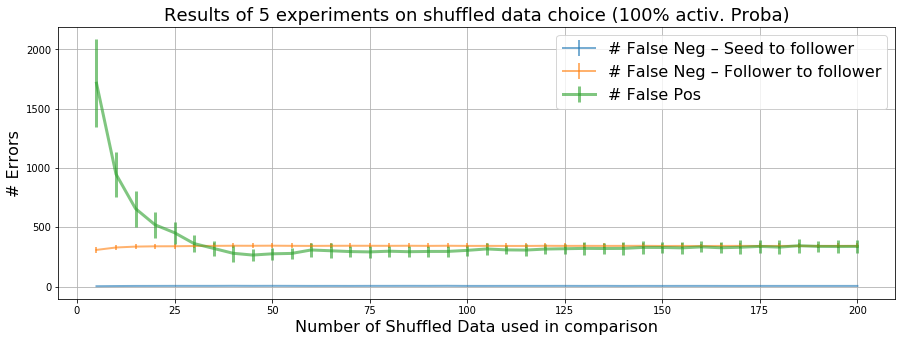

In [247]:
fig, ax = plt.subplots(figsize = (15, 5))

plt.title('Results of {} experiments on shuffled data choice (100% activ. Proba)'
          .format(n_exp), fontsize = 18)

plt.errorbar(permut_tests, fal_ne.mean(axis = 0)[:,0], 
             yerr = fal_ne.std(axis = 0)[:,0], alpha = 0.6,
             label = '# False Neg – Seed to follower', linewidth = 2)
plt.errorbar(permut_tests, fal_ne.mean(axis = 0)[:,1], 
             yerr = fal_ne.std(axis = 0)[:,1], alpha = 0.6,
             label = '# False Neg – Follower to follower', linewidth = 2)
plt.errorbar(permut_tests, fal_po.mean(axis = 0), 
             fal_po.std(axis = 0), alpha = 0.6,
             label = '# False Pos', linewidth = 3)

plt.xlabel('Number of Shuffled Data used in comparison', fontsize = 16)
plt.ylabel('# Errors', fontsize = 16)

#plt.axis([0, 205, -10, 500])
#plt.axis([1, 203, -5, 20])

plt.grid()
plt.legend(fontsize = 16)

It appears the number of random (shuffled) data used in the statistical comparison has a large impact on the number of false positives (wrong significances). The number of false negatives (missing significances) goes from ~10 to ~5 between 10 and 25 sets of random data.

## Delay Measure as fct of Encoded Delay

In [9]:
n_exp, n_reg, show_scatter = 20, 100, False

activ_proba_tests = [[5e-2, 100], [5e-2, 90]]
delay_tests = np.arange(1, 30, 1)

encoded_res = np.empty((len(activ_proba_tests), len(delay_tests), 2))
random_res = np.empty_like(encoded_res)
overall_res = np.empty_like(encoded_res)

if show_scatter:
    fig, ax = plt.subplots(figsize = (15, 5))
    plt.title('Delay Measurement Results as a Function of Encoded Delay\n'+
          '(mean and s.d. over {} Experiments – {}% replication probablity)'
          .format(n_exp, activ_proba[1]), fontsize = 20)

    plt.xlabel('Encoded Delay', fontsize = 18)
    plt.ylabel('Measured Delay consistency', fontsize = 18)
    
    plt.grid()

for ap_id, activ_proba in enumerate(activ_proba_tests):
    for del_id, enc_del in enumerate(delay_tests):

        if (del_id % np.ceil(len(delay_tests)/10) == 0):
            print('Doing delay = {}'.format(enc_del))

        encoded_measures = np.array([])
        random_measures = np.array([])
        overall_measure = np.array([])

        for exp in range(n_exp):
            dc_patt, _, expected = gen_sim_data(n_reg = n_reg, n_max_perm = 0,
                                                fol_inter = False,
                                                n_seeds = 10, n_followers = 60,
                                                activ_proba = activ_proba, delay = enc_del,
                                                noise = 0.1)

            encoded_measures = np.hstack((encoded_measures, dc_patt[expected > 0]))
            random_measures = np.hstack((random_measures, dc_patt[expected == 0]))
            overall_measure = np.hstack((overall_measure, dc_patt.flatten()))

        if show_scatter:
            plt.scatter(np.full_like(encoded_measures, enc_del), encoded_measures,
                       alpha = 0.05, c = 'tab:blue', marker = 'o')
            plt.scatter(np.full_like(random_measures, enc_del), random_measures,
                       alpha = 0.2, c = 'tab:red', marker = 'x')


        encoded_res[ap_id, del_id] = np.nanmean(encoded_measures), np.nanstd(encoded_measures)
        random_res[ap_id, del_id] = np.nanmean(random_measures), np.nanstd(random_measures)
        overall_res[ap_id, del_id] = np.nanmean(dc_patt), np.nanstd(dc_patt)

if show_scatter:
    plt.yscale('log')

Doing delay = 1
Doing delay = 4
Doing delay = 7
Doing delay = 10
Doing delay = 13
Doing delay = 16
Doing delay = 19
Doing delay = 22
Doing delay = 25
Doing delay = 28
Doing delay = 1
Doing delay = 4
Doing delay = 7
Doing delay = 10
Doing delay = 13
Doing delay = 16
Doing delay = 19
Doing delay = 22
Doing delay = 25
Doing delay = 28


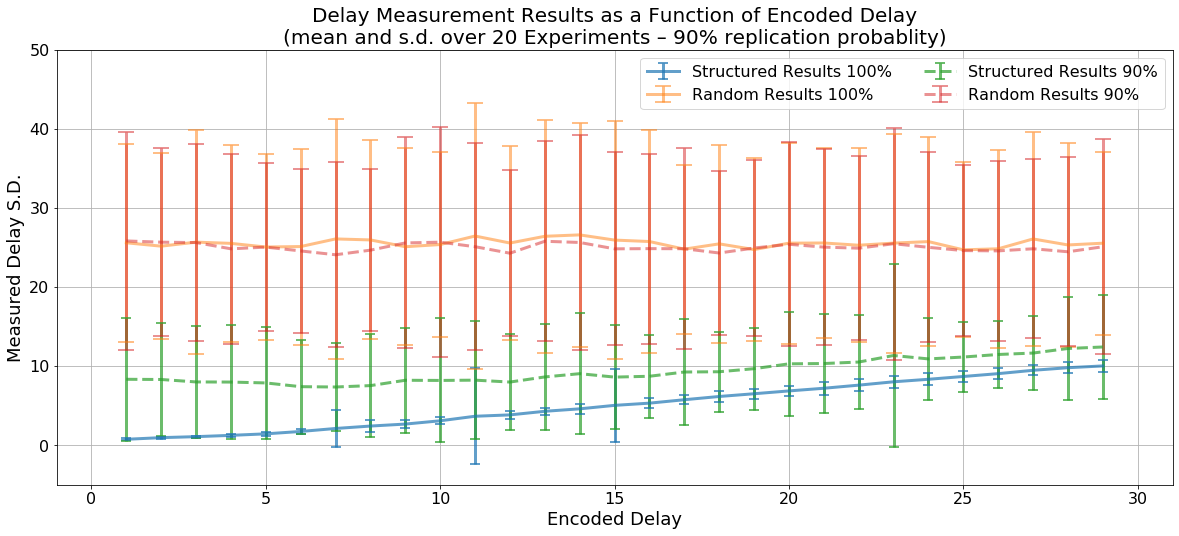

In [21]:
fig, ax = plt.subplots(figsize = (20, 8))

## Overlap shuffled data
plt.title('Delay Measurement Results as a Function of Encoded Delay\n'+
          '(mean and s.d. over {} Experiments – {}% replication probablity)'
          .format(n_exp, activ_proba[1]), fontsize = 20)

for j, plot_type in enumerate(['-', '--']):
    plt.errorbar(delay_tests, encoded_res[j, :, 0], yerr = encoded_res[j, :, 1],
                 alpha = 0.7, capsize = 5, capthick = 2, linewidth = 3, ls = plot_type,
                 label = 'Structured Results {}%'.format(100-j*10))
    plt.errorbar(delay_tests, random_res[j, :, 0], yerr = random_res[j, :, 1],
                 alpha = 0.5, capsize = 8, capthick = 2, linewidth = 3, ls = plot_type,
                 label = 'Random Results {}%'.format(100-j*10))
    #plt.errorbar(delay_tests, overall_res[j, :, 0], yerr = overall_res[j, :, 1],
    #             alpha = 0.5, linewidth = 2, ls = plot_type,
    #             label = 'Overall Results {}%'.format(100-j*10))

plt.xlabel('Encoded Delay', fontsize = 18)
plt.ylabel('Measured Delay S.D.', fontsize = 18)
plt.tick_params(labelsize = 16)

plt.axis([-1, 31, -5, 50])

plt.legend(fontsize = 16, ncol = 2)
plt.grid()

## Validation with threshold on relative z-score (zmap)

In [36]:
# Simulation Parameters
n_reg, n_timep, n_perm = 40, 800, 20
# Number of experiments
n_tests = 10
# zScore Thresholds
threshz = np.arange(2, 8, 0.2)

false_neg = np.empty((n_tests, len(threshz), 2))
false_pos = np.empty((n_tests, len(threshz)))

n_sim_seed = np.zeros(n_tests)

for test in range(n_tests):
    print('Test {}...'.format(test + 1))
    simulation, seed_id, fol_id, seed_choice = fmri_delay.simulate_activation(
        n_regions = n_reg, n_timepoints = n_timep,
        n_seeds = 10, n_followers = 20,
        activ_proba = [5e-2, 95], delay = 5,
        noise = 0.2)

    # Delay measurement on patterned data
    _, del_std_pattern = fmri_delay.delay_measure(simulation, pre_thresh = 1)

    # Permutation of innovations
    sim_perm = fmri_delay.permute_innovations(simulation, n_perm)

    del_std_perm = np.empty((n_perm, n_reg, n_reg))
    
    # Delay measurement on permuted data
    for permut_id, permut in enumerate(sim_perm):
        _, del_std_perm[permut_id] = fmri_delay.delay_measure(permut, pre_thresh = 1)

    # Computation of ideal results from encoded structure
    expected = fmri_delay.get_encoded_structure(seed_choice, fol_id, n_reg, True)
    print(len(expected[expected == 0.5]), 'potential interactions between followers')

    # Number of interactions between followers with similar seeds
    for unique_seed in np.unique((seed_choice)):
        which = (seed_choice == unique_seed)
        n_sim_seed[test] += sum(1 for _ in permutations(seed_choice[which], 2))
    
    for t_id, thresh in enumerate(threshz):
        bin_z, _ = fmri_delay.binarize_results(1/del_std_pattern,
                                               1/del_std_perm,
                                               thresh = thresh)

        false_neg[test, t_id], false_pos[test, t_id] = fmri_delay.recovery_score(bin_z,
                                                                                 expected,
                                                                                 True)

Test 1...
32 potential interaction between followers...
Test 2...
40 potential interaction between followers...
Test 3...
44 potential interaction between followers...
Test 4...
36 potential interaction between followers...
Test 5...
58 potential interaction between followers...
Test 6...
64 potential interaction between followers...
Test 7...
34 potential interaction between followers...
Test 8...
44 potential interaction between followers...
Test 9...
44 potential interaction between followers...
Test 10...
28 potential interaction between followers...


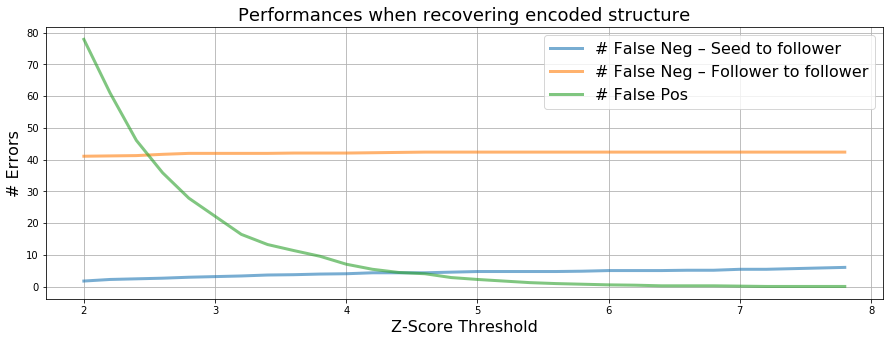

In [39]:
fig, ax = plt.subplots(figsize = (15, 5))
plt.title('Performances when recovering encoded structure', fontsize = 18)

plt.plot(threshz, false_neg[:, :, 0].mean(axis = 0), alpha = 0.6,
         label = '# False Neg – Seed to follower', linewidth = 3)
plt.plot(threshz, false_neg[:, :, 1].mean(axis = 0), alpha = 0.6,
         label = '# False Neg – Follower to follower', linewidth = 3)
plt.plot(threshz, false_pos.mean(axis = 0), alpha = 0.6,
         label = '# False Pos', linewidth = 3)

plt.xlabel('Z-Score Threshold', fontsize = 16)
plt.ylabel('# Errors', fontsize = 16)

#plt.axis([1.75, 7.25, -10, 20])
#plt.axis([2, 7, -10, 30])

plt.grid()
plt.legend(fontsize = 16)